In [24]:
%cd /local/data0/home/naumanb/DLNN/BTCV/BTCV

/local/data0/home/naumanb/DLNN/BTCV/BTCV


In [25]:
!conda activate nauman_gpu

In [6]:
!ls

data/	  optimizers/	      __pycache__/  runs/     trainer.py*
dataset/  outputs/	      RawData/	    runsO/    utils/
main.py*  pretrained_models/  RawData.zip*  test.py*


## **Swin UNETR  forBTCV**

In this notebook, SwinUNETR is trained on BTCV dataset

The notebook contains 3 main sections

#### **1 Dataloader** 
    # Visualizing data loading from BTCV
#### **2 Training**
    # In the root directory I have provided the configuration file (config.ini)
    # Load the parameters 
    # Load SwinUnetR
        # SwinUnetR* and its submodules are in SwinUnetR folder
            # Swin_UnetR.py
            # Swin_Tansfomerblock
            # Patch_merging
            # comon
                # window_partition
                # window_reverse
                # get_window_size
                # compute_mask
        *The modules that are taken from other paper/resources are explicily mentioned in each file
    # the tesnsorboard graph of training could be seen here:
    https://tensorboard.dev/experiment/iYsNW9B3TGehd1299SaPvw/#scalars
       
        
#### **3 Testing**
    # Load model trained in Section 2
    # Run testing

In [ ]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [10]:
import os
import shutil
import tempfile
from functools import partial
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import numpy as np
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.parallel
import torch.utils.data.distributed
from optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from trainer import run_training
from utils.data_utils import get_loader


from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete, Compose
from monai.utils.enums import MetricReduction

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.4
Pytorch version: 2.0.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.12.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

In [30]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

# **DataLoader**

In [31]:
data_dir = "data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

set_track_meta(False)

Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,802 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,803 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,803 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,804 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,804 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,805 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-09 20:49:24,805 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:24,805 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,012 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,044 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,306 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,344 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,359 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,426 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,554 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:26,671 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:27,905 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:28,452 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:28,682 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:28,726 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:   4%|▍         | 1/24 [00:04<01:33,  4.08s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:28,880 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:28,946 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,019 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,415 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,475 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,585 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,736 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:29,821 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:30,042 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:30,316 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  12%|█▎        | 3/24 [00:05<00:35,  1.70s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:30,610 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:31,577 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:31,656 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:31,744 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  38%|███▊      | 9/24 [00:07<00:08,  1.79it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:31,813 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:31,925 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,052 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  42%|████▏     | 10/24 [00:07<00:07,  1.92it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,117 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,222 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,387 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  62%|██████▎   | 15/24 [00:07<00:02,  3.30it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,642 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,649 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:32,846 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:33,255 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:33,359 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:33,405 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:34,176 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  67%|██████▋   | 16/24 [00:09<00:04,  1.90it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:34,773 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:   0%|          | 0/6 [00:00<?, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:36,645 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:36,646 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:36,647 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:36,647 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:37,319 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:37,333 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:37,364 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:38,095 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:39,346 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  17%|█▋        | 1/6 [00:02<00:14,  2.95s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:39,596 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:39,858 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 20:49:40,992 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


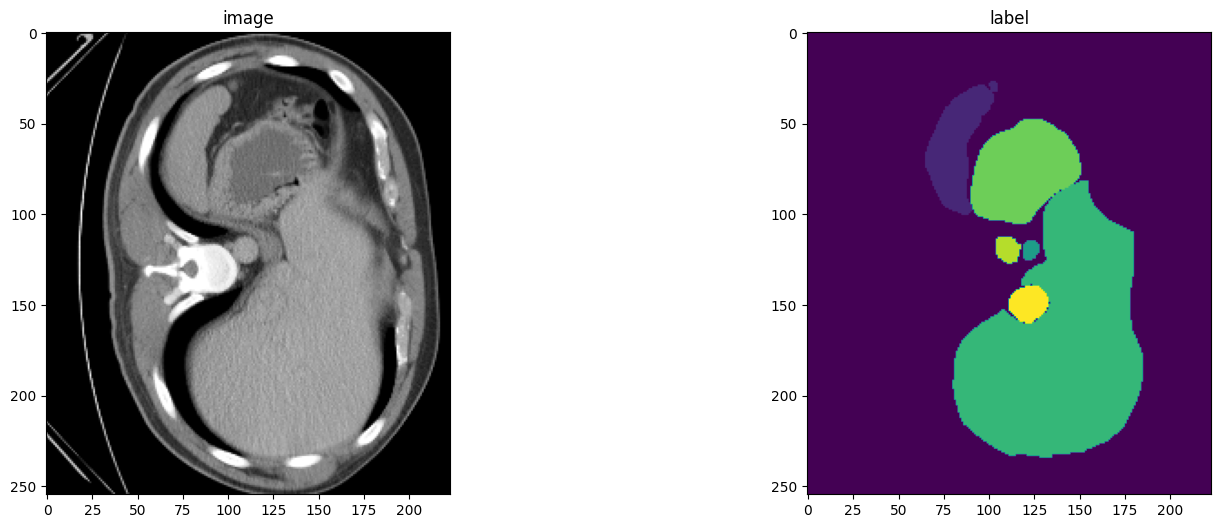

In [32]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

# **Training things**

In [1]:
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

checkpoint = config['DEFAULT']['checkpoint']
logdir = config['DEFAULT']['logdir']
pretrained_dir = config['DEFAULT']['pretrained_dir']
data_dir = config['DEFAULT']['data_dir']
json_list = config['DEFAULT']['json_list']
pretrained_model_name = config['DEFAULT']['pretrained_model_name']
save_checkpoint = config.getboolean('DEFAULT', 'save_checkpoint')
max_epochs = config.getint('DEFAULT', 'max_epochs')
batch_size = config.getint('DEFAULT', 'batch_size')
sw_batch_size = config.getint('DEFAULT', 'sw_batch_size')
optim_lr = config.getfloat('DEFAULT', 'optim_lr')
optim_name = config['DEFAULT']['optim_name']
reg_weight = config.getfloat('DEFAULT', 'reg_weight')
momentum = config.getfloat('DEFAULT', 'momentum')
noamp = config.getboolean('DEFAULT', 'noamp')
val_every = config.getint('DEFAULT', 'val_every')
distributed = config.getboolean('DEFAULT', 'distributed')
world_size = config.getint('DEFAULT', 'world_size')
rank = config.getint('DEFAULT', 'rank')
dist_url = config['DEFAULT']['dist-url']
dist_backend = config['DEFAULT']['dist-backend']
norm_name = config['DEFAULT']['norm_name']
workers = config.getint('DEFAULT', 'workers')
feature_size = config.getint('DEFAULT', 'feature_size')
in_channels = config.getint('DEFAULT', 'in_channels')
out_channels = config.getint('DEFAULT', 'out_channels')
use_normal_dataset = config.getboolean('DEFAULT', 'use_normal_dataset')
a_min = config.getfloat('DEFAULT', 'a_min')
a_max = config.getfloat('DEFAULT', 'a_max')
b_min = config.getfloat('DEFAULT', 'b_min')
b_max = config.getfloat('DEFAULT', 'b_max')
space_x = config.getfloat('DEFAULT', 'space_x')
space_y = config.getfloat('DEFAULT', 'space_y')
space_z = config.getfloat('DEFAULT', 'space_z')
roi_x = config.getint('DEFAULT', 'roi_x')
roi_y = config.getint('DEFAULT', 'roi_y')
roi_z = config.getint('DEFAULT', 'roi_z')
dropout_rate = config.getfloat('DEFAULT', 'dropout_rate')
dropout_path_rate = config.getfloat('DEFAULT', 'dropout_path_rate')
RandFlipd_prob = config.getfloat('DEFAULT', 'RandFlipd_prob')
RandRotate90d_prob = config.getfloat('DEFAULT', 'RandRotate90d_prob')
RandScaleIntensityd_prob = config.getfloat('DEFAULT', 'RandScaleIntensityd_prob')
RandShiftIntensityd_prob = config.getfloat('DEFAULT', 'RandShiftIntensityd_prob')
infer_overlap = config.getfloat('DEFAULT', 'infer_overlap')
lrschedule = config['DEFAULT']['lrschedule']
warmup_epochs = config.getint('DEFAULT', 'warmup_epochs')
resume_ckpt = config.getboolean('DEFAULT', 'resume_ckpt')
smooth_dr = config.getfloat('DEFAULT', 'smooth_dr')
smooth_nr = config.getfloat('DEFAULT', 'smooth_nr')

use_ssl_pretrained = config.getboolean('DEFAULT', 'use_ssl_pretrained')
use_checkpoint = config.getboolean('DEFAULT', 'use_checkpoint')
spatial_dims =config.getint('DEFAULT', 'spatial_dims')
squared_dice =config.getboolean('DEFAULT', 'squared_dice')

In [13]:

def main():
    logdir = "./runs/"
    if distributed:
        ngpus_per_node = torch.cuda.device_count()
        print("Found total gpus",ngpus_per_node)
        world_size =1
        print("world_size", world_size)
        world_size = ngpus_per_node * world_size
        mp.spawn(main_worker, nprocs=ngpus_per_node)
        # mp.start_processes(main_worker, nprocs=ngpus_per_node, start_method="fork")  # should print 0 1
    else:
        print("ELSE")
        main_worker(gpu=0)

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from SwinUnetR.Swin_UnetR import SwinUNETR

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [9]:
weight = torch.load("/local/data0/home/naumanb/DLNN/BTCV/BTCV/pretrained_models/model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


In [3]:


def main_worker(gpu):

    if distributed:
        print("Fist  DIS")
        torch.multiprocessing.set_start_method("fork", force=True)
    np.set_printoptions(formatter={"float": "{: 0.3f}".format}, suppress=True)
    gpu = gpu
    
    if distributed:
        print("2nD  DIS")
        rank = config.getint('DEFAULT', 'rank')
        ngpus_per_node = torch.cuda.device_count()
        rank = rank * ngpus_per_node + gpu
        dist.init_process_group(
            backend=dist_backend, init_method=dist_url, world_size=world_size, rank=rank
        )
        
    torch.cuda.set_device(gpu)
    torch.backends.cudnn.benchmark = True
    test_mode = False
    loader = get_loader()
    rank= config.getint('DEFAULT', 'rank')
    print(rank, " gpu", gpu)
    if rank == 0:
        print("Batch size is:", batch_size, "epochs", max_epochs)
    inf_size = [roi_x, roi_y, roi_z]

    pretrained_dir = config['DEFAULT']['pretrained_dir']
    model = SwinUNETR(
        img_size=(roi_x, roi_y, roi_z),
        in_channels=in_channels,
        out_channels=out_channels,
        feature_size=feature_size,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=dropout_path_rate,
        use_checkpoint=use_checkpoint,
    )

    if resume_ckpt:
        model_dict = torch.load(os.path.join(pretrained_dir, pretrained_model_name))["state_dict"]
        model.load_state_dict(model_dict)
        print("Use pretrained weights")

    if use_ssl_pretrained:
        try:
            model_dict = torch.load("/local/data0/home/naumanb/DLNN/BTCV/BTCV/pretrained_models/model_swinvit.pt")
            state_dict = model_dict["state_dict"]
          
            if "module." in list(state_dict.keys())[0]:
                print("Tag 'module.' found in state dict - fixing!")
                for key in list(state_dict.keys()):
                    state_dict[key.replace("module.", "")] = state_dict.pop(key)
            if "swin_vit" in list(state_dict.keys())[0]:
                print("Tag 'swin_vit' found in state dict - fixing!")
                for key in list(state_dict.keys()):
                    state_dict[key.replace("swin_vit", "swinViT")] = state_dict.pop(key)
            model.load_state_dict(state_dict, strict=False)
            print("Using pretrained self-supervised Swin UNETR backbone weights !")
        except ValueError:
            raise ValueError("Self-supervised pre-trained weights not available for" + str(model_name))

    if squared_dice:
        dice_loss = DiceCELoss(
            to_onehot_y=True, softmax=True, squared_pred=True, smooth_nr=smooth_nr, smooth_dr=smooth_dr
        )
    else:
        dice_loss = DiceCELoss(to_onehot_y=True, softmax=True)
    # post_label = AsDiscrete(to_onehot=True, n_classes=out_channels)
    post_label = AsDiscrete(to_onehot=14)
    
    # post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=out_channels)
    post_pred = AsDiscrete(argmax=True, to_onehot=14)
    
    dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN, get_not_nans=True)
    model_inferer = partial(
        sliding_window_inference,
        roi_size=inf_size,
        sw_batch_size=sw_batch_size,
        predictor=model,
        overlap=infer_overlap,
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total parameters count", pytorch_total_params)

    best_acc = 0
    start_epoch = 0
    
    checkpoint = config['DEFAULT']['checkpoint']
    checkpoint = False
    print("checkpoint", checkpoint)  
    if checkpoint:
        checkpoint = torch.load(checkpoint, map_location="cpu")
        from collections import OrderedDict

        new_state_dict = OrderedDict()
        for k, v in checkpoint["state_dict"].items():
            new_state_dict[k.replace("backbone.", "")] = v
        model.load_state_dict(new_state_dict, strict=False)
        if "epoch" in checkpoint:
            start_epoch = checkpoint["epoch"]
        if "best_acc" in checkpoint:
            best_acc = checkpoint["best_acc"]
        print("=> loaded checkpoint '{}' (epoch {}) (bestacc {})".format(checkpoint, start_epoch, best_acc))

    model.cuda(gpu)

    if distributed:
        torch.cuda.set_device(gpu)
        if norm_name == "batch":
            model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        model.cuda(gpu)
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu], output_device=gpu)
    if optim_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=optim_lr, weight_decay=reg_weight)
    elif optim_name == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=optim_lr, weight_decay=reg_weight)
    elif optim_name == "sgd":
        optimizer = torch.optim.SGD(
            model.parameters(), lr=optim_lr, momentum=momentum, nesterov=True, weight_decay=reg_weight
        )
    else:
        raise ValueError("Unsupported Optimization Procedure: " + str(optim_name))

    if lrschedule == "warmup_cosine":
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer, warmup_epochs=warmup_epochs, max_epochs=max_epochs
        )
    elif lrschedule == "cosine_anneal":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
        if checkpoint is not None:
            scheduler.step(epoch=start_epoch)
    else:
        scheduler = None
    accuracy = run_training(
        model=model,
        train_loader=loader[0],
        val_loader=loader[1],
        optimizer=optimizer,
        loss_func=dice_loss,
        acc_func=dice_acc,
        model_inferer=model_inferer,
        scheduler=scheduler,
        start_epoch=start_epoch,
        post_label=post_label,
        post_pred=post_pred,
    )
    return accuracy


if __name__ == "__main__":
    main()


Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2023-04-08 00:30:21.962398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found total gpus 2


Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
2023-04-08 00:30:29.495029: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-08 00:30:29.533838: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2023-04-08 00:30:31,106 - Added key: store_based_barrier_key:1 to store for rank: 0
2023-04-08 00:30:31,106 - Added key: store_based_barrier_key:1 to store for rank: 1
2023-04-08 00:30:31,106 - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
2023-04-08 00:30:31,116 - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
2023-04-08 00:30:31,178 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,179 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,179 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,183 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,184 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,186 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:31,186 - pixdim[0] (qfac) should be 1 (default) or 

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac

2023-04-08 00:30:32,417 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:32,527 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:32,602 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:32,696 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:32,849 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:32,865 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:32,866 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:33,027 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:33,053 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:33,213 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:33,391 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:33,472 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:33,509 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:33,637 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:33,888 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:33,934 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:35,961 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:36,553 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:37,169 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:37,435 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:37,588 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:   4%|▍         | 1/24 [00:07<02:45,  7.18s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:   8%|▊         | 2/24 [00:07<01:06,  3.03s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:38,338 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:38,380 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:38,446 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:38,519 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:   4%|▍         | 1/24 [00:07<02:52,  7.50s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:38,686 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:38,752 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:39,078 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:39,099 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:39,188 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:39,207 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:40,000 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,155 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:40,356 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,360 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,419 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:40,692 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,826 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,835 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,835 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:  12%|█▎        | 3/24 [00:09<00:58,  2.77s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:40,905 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,913 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:40,953 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:  12%|█▎        | 3/24 [00:10<01:01,  2.94s/it]

2023-04-08 00:30:41,123 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:41,327 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:41,346 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:43,297 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:43,341 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:  38%|███▊      | 9/24 [00:12<00:14,  1.05it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:43,870 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:43,947 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:43,976 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:44,023 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:44,755 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:44,849 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:45,117 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:45,121 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:45,216 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Loading dataset:  38%|███▊      | 9/24 [00:14<00:18,  1.26s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:45,548 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:45,639 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:45,765 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:45,967 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:46,026 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  42%|████▏     | 10/24 [00:15<00:16,  1.19s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:46,291 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:46,472 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:46,473 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:46,780 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:46,876 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:47,225 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:47,514 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:47,601 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:48,042 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:48,054 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:48,473 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:48,592 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:48,923 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:49,004 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:30:49,107 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:49,230 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  79%|███████▉  | 19/24 [00:19<00:03,  1.62it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:50,734 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset:  75%|███████▌  | 18/24 [00:19<00:04,  1.24it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:30:51,375 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loading dataset: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


0  gpu 0
Batch size is: 1 epochs 5000


Loading dataset: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


1  gpu 1
Tag 'module.' found in state dict - fixing!
Using pretrained self-supervised Swin UNETR backbone weights !
Total parameters count 62187296
Tag 'module.' found in state dict - fixing!
Using pretrained self-supervised Swin UNETR backbone weights !
Total parameters count 62187296
Writing Tensorboard logs to  ./runs/test
01  Sat Apr  8 00:30:56 2023Sat Apr  8 00:30:56 2023  Epoch:Epoch:  00

Epoch 0/5000 0/12 loss: 3.4944 time 10.49s
2023-04-08 00:31:07,088 - Reducer buckets have been rebuilt in this iteration.
2023-04-08 00:31:07,088 - Reducer buckets have been rebuilt in this iteration.
Epoch 0/5000 1/12 loss: 3.4929 time 0.92s
Epoch 0/5000 2/12 loss: 3.4967 time 0.89s
Epoch 0/5000 3/12 loss: 3.5008 time 0.89s
Epoch 0/5000 4/12 loss: 3.5058 time 0.89s
Epoch 0/5000 5/12 loss: 3.5107 time 0.89s
Epoch 0/5000 6/12 loss: 3.5098 time 0.89s
Epoch 0/5000 7/12 loss: 3.5088 time 0.89s
Epoch 0/5000 8/12 loss: 3.5105 time 0.89s
Epoch 0/5000 9/12 loss: 3.5099 time 0.89s
Epoch 0/5000 10/12 lo

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:50:44,501 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:50:44,561 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:50:44,621 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 00:50:44,684 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:50:45,264 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 00:50:45,631 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Local rank information for native distributed setting will be initialized using a heuristic approach based on the hostnames. In some corner cases, determined local rank can be different from the real setup. To avoid this warning, please either set `os.environ['LOCAL_RANK']` or use `idist.set_local_rank(local_rank)` with correct local rank index.
Local rank information for native distributed setting will be initialized using a heuristic approach based on the hostnames. In some corner cases, determined local rank can be different from the real setup. To avoid this warning, please either set `os.environ['LOCAL_RANK']` or use `idist.set_local_rank(local_rank)` with correct local rank index.


2023-04-08 00:50:55,959 - Added key: store_based_barrier_key:2 to store for rank: 0
2023-04-08 00:50:55,959 - Added key: store_based_barrier_key:2 to store for rank: 1
2023-04-08 00:50:55,959 - Rank 0: Completed store-based barrier for key:store_based_barrier_key:2 with 2 nodes.
2023-04-08 00:50:55,959 - Rank 1: Completed store-based barrier for key:store_based_barrier_key:2 with 2 nodes.
Val 99/5000 0/3 acc 0.4471572 time 12.32s
Val 99/5000 1/3 acc 0.4251286 time 12.72s
Val 99/5000 2/3 acc 0.42232767 time 9.16s
Final validation  99/4999 acc 0.42232767 time 34.26s
new best (0.000000 --> 0.422328). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
10 Sat Apr  8 00:51:21 2023  Sat Apr  8 00:51:21 2023Epoch:  Epoch:100 
100
Epoch 100/5000 0/12 loss: 1.0434 time 1.76s
Epoch 100/5000 1/12 loss: 1.0653 time 0.89s
Epoch 100/5000 2/12 loss: 1.0675 time 0.89s
Epoch 100/5000 3/12 loss: 1.0869 time 0.89s
Epoch 100/5000 4/12

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:11:01,216 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,216 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,216 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,220 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,220 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,220 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:11:01,695 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,846 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:11:01,856 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:11:01,909 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:11:02,541 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:11:02,778 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 199/5000 0/3 acc 0.62485063 time 12.82s
Val 199/5000 1/3 acc 0.622705 time 11.70s
Val 199/5000 2/3 acc 0.6322624 time 9.13s
Final validation  199/4999 acc 0.6322624 time 33.75s
new best (0.422328 --> 0.632262). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 01:11:37 2023 Epoch: 200
1 Sat Apr  8 01:11:37 2023 Epoch: 200
Epoch 200/5000 0/12 loss: 0.8694 time 1.83s
Epoch 200/5000 1/12 loss: 0.8936 time 0.89s
Epoch 200/5000 2/12 loss: 0.9029 time 0.89s
Epoch 200/5000 3/12 loss: 0.8517 time 0.90s
Epoch 200/5000 4/12 loss: 0.8654 time 0.89s
Epoch 200/5000 5/12 loss: 0.8582 time 0.90s
Epoch 200/5000 6/12 loss: 0.8761 time 0.89s
Epoch 200/5000 7/12 loss: 0.8732 time 0.89s
Epoch 200/5000 8/12 loss: 0.8612 time 0.89s
Epoch 200/5000 9/12 loss: 0.8564 time 0.89s
Epoch 200/5000 10/12 loss: 0.8452 time 0.89s
Epoch 200/

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:31:18,718 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:18,718 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:18,718 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:18,753 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:18,754 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:18,754 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:31:19,205 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:19,258 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:19,364 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:19,378 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:31:20,389 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:31:20,393 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 299/5000 0/3 acc 0.74216735 time 12.89s
Val 299/5000 1/3 acc 0.7227116 time 11.47s
Val 299/5000 2/3 acc 0.730627 time 9.14s
Final validation  299/4999 acc 0.730627 time 33.60s
new best (0.632262 --> 0.730627). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
01 Sat Apr  8 01:31:54 2023 Epoch:  300Sat Apr  8 01:31:54 2023 
Epoch: 300
Epoch 300/5000 0/12 loss: 0.8808 time 2.27s
Epoch 300/5000 1/12 loss: 0.8557 time 0.89s
Epoch 300/5000 2/12 loss: 0.7905 time 0.89s
Epoch 300/5000 3/12 loss: 0.7680 time 0.89s
Epoch 300/5000 4/12 loss: 0.7503 time 0.89s
Epoch 300/5000 5/12 loss: 0.7274 time 0.89s
Epoch 300/5000 6/12 loss: 0.7325 time 0.89s
Epoch 300/5000 7/12 loss: 0.7493 time 0.89s
Epoch 300/5000 8/12 loss: 0.7604 time 0.89s
Epoch 300/

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:51:36,187 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:51:36,331 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:51:36,335 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 01:51:36,363 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:51:36,961 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 01:51:37,209 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 399/5000 0/3 acc 0.8280381 time 12.37s
Val 399/5000 1/3 acc 0.8049583 time 11.45s
Val 399/5000 2/3 acc 0.8104732 time 9.12s
Final validation  399/4999 acc 0.8104732 time 33.01s
new best (0.730627 --> 0.810473). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 01:52:11 2023 Epoch: 400
1 Sat Apr  8 01:52:11 2023 Epoch: 400
Epoch 400/5000 0/12 loss: 0.5823 time 1.83s
Epoch 400/5000 1/12 loss: 0.6371 time 0.89s
Epoch 400/5000 2/12 loss: 0.6732 time 0.89s
Epoch 400/5000 3/12 loss: 0.6780 time 0.89s
Epoch 400/5000 4/12 loss: 0.6837 time 0.89s
Epoch 400/5000 5/12 loss: 0.6938 time 0.89s
Epoch 400/5000 6/12 loss: 0.6758 time 0.89s
Epoch 400/5000 7/12 loss: 0.6926 time 0.89s
Epoch 400/5000 8/12 loss: 0.7362 time 0.88s
Epoch 400/5000 9/12 loss: 0.7306 time 0.89s
Epoch 400/5000 10/12 loss: 0.7322 time 0.89s
Epoch 400/

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:11:50,480 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:50,480 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:50,480 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:50,519 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:50,519 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:50,519 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:11:51,033 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:51,058 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:51,120 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:11:51,143 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:11:51,981 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:11:52,192 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 499/5000 0/3 acc 0.8320291 time 12.57s
Val 499/5000 1/3 acc 0.81162775 time 11.41s
Val 499/5000 2/3 acc 0.8180937 time 9.12s
Final validation  499/4999 acc 0.8180937 time 33.17s
new best (0.810473 --> 0.818094). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 02:12:26 20231 Epoch: 500
 Sat Apr  8 02:12:26 2023 Epoch: 500
Epoch 500/5000 0/12 loss: 0.6803 time 1.85s
Epoch 500/5000 1/12 loss: 0.7230 time 0.89s
Epoch 500/5000 2/12 loss: 0.7290 time 0.89s
Epoch 500/5000 3/12 loss: 0.6879 time 0.89s
Epoch 500/5000 4/12 loss: 0.6952 time 0.89s
Epoch 500/5000 5/12 loss: 0.6796 time 0.89s
Epoch 500/5000 6/12 loss: 0.6681 time 0.89s
Epoch 500/5000 7/12 loss: 0.6790 time 0.89s
Epoch 500/5000 8/12 loss: 0.6712 time 0.89s
Epoch 500/5000 9/12 loss: 0.6754 time 0.89s
Epoch 500/5000 10/12 loss: 0.6745 time 0.89s
Epoch 500

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:32:04,506 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:04,506 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:04,506 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:04,533 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:04,533 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:04,533 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:32:04,979 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:05,039 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:05,101 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:32:05,187 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:32:05,808 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:32:05,897 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 599/5000 0/3 acc 0.8436402 time 12.41s
Val 599/5000 1/3 acc 0.8226252 time 11.45s
Val 599/5000 2/3 acc 0.8312013 time 9.12s
Final validation  599/4999 acc 0.8312013 time 33.05s
new best (0.818094 --> 0.831201). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
10  Sat Apr  8 02:32:41 2023Sat Apr  8 02:32:41 2023  Epoch:Epoch:  600600

Epoch 600/5000 0/12 loss: 0.6391 time 1.97s
Epoch 600/5000 1/12 loss: 0.6007 time 0.89s
Epoch 600/5000 2/12 loss: 0.5938 time 0.89s
Epoch 600/5000 3/12 loss: 0.6268 time 0.89s
Epoch 600/5000 4/12 loss: 0.6253 time 0.89s
Epoch 600/5000 5/12 loss: 0.6260 time 0.89s
Epoch 600/5000 6/12 loss: 0.6280 time 0.89s
Epoch 600/5000 7/12 loss: 0.6323 time 0.89s
Epoch 600/5000 8/12 loss: 0.6355 time 0.89s
Epoch 600

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:52:20,264 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:52:20,331 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:52:20,390 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 02:52:20,417 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:52:21,037 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 02:52:21,305 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 699/5000 0/3 acc 0.8432027 time 12.34s
Val 699/5000 1/3 acc 0.8220047 time 11.45s
Val 699/5000 2/3 acc 0.8293607 time 9.11s
Final validation  699/4999 acc 0.8293607 time 32.96s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 02:52:53 2023 Epoch: 1700
 Sat Apr  8 02:52:53 2023 Epoch: 700
Epoch 700/5000 0/12 loss: 0.5605 time 1.75s
Epoch 700/5000 1/12 loss: 0.5915 time 0.89s
Epoch 700/5000 2/12 loss: 0.6152 time 0.89s
Epoch 700/5000 3/12 loss: 0.6427 time 0.89s
Epoch 700/5000 4/12 loss: 0.6412 time 0.89s
Epoch 700/5000 5/12 loss: 0.6599 time 0.89s
Epoch 700/5000 6/12 loss: 0.6525 time 0.89s
Epoch 700/5000 7/12 loss: 0.6567 time 0.89s
Epoch 700/5000 8/12 loss: 0.6336 time 0.89s
Epoch 700/5000 9/12 loss: 0.6270 time 0.90s
Epoch 700/5000 10/12 loss: 0.6184 time 0.89s
Epoch 700/5000 11/12 loss: 0.6221 time 0.89s
Final training  700/4999 loss: 0.6221 time 11.70s
0 Sat Apr  8 02:53:04 2023 E

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:12:31,425 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,425 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,425 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,460 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,460 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,460 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:12:31,969 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:31,992 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:32,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:32,067 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:12:32,945 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:12:33,059 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 799/5000 0/3 acc 0.8513775 time 12.62s
Val 799/5000 1/3 acc 0.8298 time 11.44s
Val 799/5000 2/3 acc 0.8344044 time 9.12s
Final validation  799/4999 acc 0.8344044 time 33.27s
new best (0.831201 --> 0.834404). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 03:13:07 2023 Epoch: 800
1 Sat Apr  8 03:13:07 2023 Epoch: 800
Epoch 800/5000 0/12 loss: 0.5014 time 1.70s
Epoch 800/5000 1/12 loss: 0.5315 time 0.89s
Epoch 800/5000 2/12 loss: 0.5908 time 0.89s
Epoch 800/5000 3/12 loss: 0.5968 time 0.89s
Epoch 800/5000 4/12 loss: 0.6196 time 0.89s
Epoch 800/5000 5/12 loss: 0.6132 time 0.89s
Epoch 800/5000 6/12 loss: 0.6126 time 0.89s
Epoch 800/5000 7/12 loss: 0.6199 time 0.89s
Epoch 800/5000 8/12 loss: 0.6170 time 0.89s
Epoch 800/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:32:46,921 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:46,921 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:46,921 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:46,960 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:46,960 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:46,960 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:32:47,409 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:47,470 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:47,542 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:47,589 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:32:48,629 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:32:48,633 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 899/5000 0/3 acc 0.84853196 time 13.07s
Val 899/5000 1/3 acc 0.82517636 time 11.43s
Val 899/5000 2/3 acc 0.8342741 time 9.12s
Final validation  899/4999 acc 0.8342741 time 33.71s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 03:33:20 2023 Epoch: 1900
 Sat Apr  8 03:33:20 2023 Epoch: 900
Epoch 900/5000 0/12 loss: 0.6995 time 1.88s
Epoch 900/5000 1/12 loss: 0.5789 time 0.89s
Epoch 900/5000 2/12 loss: 0.6316 time 0.89s
Epoch 900/5000 3/12 loss: 0.6426 time 0.89s
Epoch 900/5000 4/12 loss: 0.6529 time 0.89s
Epoch 900/5000 5/12 loss: 0.6454 time 0.89s
Epoch 900/5000 6/12 loss: 0.6394 time 0.89s
Epoch 900/5000 7/12 loss: 0.6368 time 0.90s
Epoch 900/5000 8/12 loss: 0.6410 time 0.89s
Epoch 900/5000 9/12 loss: 0.6464 time 0.89s
Epoch 900/5000 10/12 loss: 0.6498 time 0.89s
Epoch 900/5000 11/12 loss: 0.64

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:53:00,915 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:00,915 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:00,915 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:00,948 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:00,948 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:00,948 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:53:01,438 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:01,496 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:01,580 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 03:53:01,593 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:53:02,241 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 03:53:02,495 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 999/5000 0/3 acc 0.84675527 time 12.76s
Val 999/5000 1/3 acc 0.8244617 time 11.43s
Val 999/5000 2/3 acc 0.82598335 time 9.12s
Final validation  999/4999 acc 0.82598335 time 33.38s
Saving checkpoint ./runs/test/model_final.pt
10 Sat Apr  8 03:53:34 2023  Epoch:Sat Apr  8 03:53:34 2023  1000Epoch:
 1000
Epoch 1000/5000 0/12 loss: 0.6240 time 1.89s
Epoch 1000/5000 1/12 loss: 0.6226 time 0.89s
Epoch 1000/5000 2/12 loss: 0.6091 time 0.89s
Epoch 1000/5000 3/12 loss: 0.6054 time 0.89s
Epoch 1000/5000 4/12 loss: 0.6150 time 0.89s
Epoch 1000/5000 5/12 loss: 0.6151 time 0.89s
Epoch 1000/5000 6/12 loss: 0.6034 time 0.89s
Epoch 1000/5000 7/12 loss: 0.6238 time 0.89s
Epoch 1000/5000 8/12 loss: 0.6233 time 0.89s
Epoch 1000/5000 9/12 loss: 0.6335 time 0.89s
Epoch 1000/5000 10/12 loss: 0.6415 time 0.89s
Epoch 1000/5000 11/12 loss: 0.6442 time 0.89s
Final training  1000/4999 loss: 0.6442 time 11.84s
1 Sat Apr 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:13:13,050 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,050 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,050 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,093 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,093 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,093 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:13:13,524 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,650 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,694 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:13,721 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:13:14,746 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:13:14,773 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1099/5000 0/3 acc 0.8556379 time 12.93s
Val 1099/5000 1/3 acc 0.8356334 time 11.44s
Val 1099/5000 2/3 acc 0.84332377 time 9.12s
Final validation  1099/4999 acc 0.84332377 time 33.60s
new best (0.834404 --> 0.843324). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 04:13:49 2023 Epoch: 1100
1 Sat Apr  8 04:13:49 2023 Epoch: 1100
Epoch 1100/5000 0/12 loss: 0.7111 time 1.93s
Epoch 1100/5000 1/12 loss: 0.6908 time 0.89s
Epoch 1100/5000 2/12 loss: 0.6428 time 0.89s
Epoch 1100/5000 3/12 loss: 0.5850 time 0.89s
Epoch 1100/5000 4/12 loss: 0.5916 time 0.89s
Epoch 1100/5000 5/12 loss: 0.5825 time 0.89s
Epoch 1100/5000 6/12 loss: 0.6035 time 0.89s
Epoch 1100/5000 7/12 loss: 0.6073 time 0.89s
Epoch 1100/5000 8/12 loss: 0.6050 tim

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:33:27,949 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:27,949 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:27,949 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:27,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:27,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:27,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:33:28,432 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:28,561 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:28,584 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:28,588 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:33:29,641 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:33:29,653 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1199/5000 0/3 acc 0.85532737 time 13.08s
Val 1199/5000 1/3 acc 0.8286878 time 11.44s
Val 1199/5000 2/3 acc 0.83704656 time 9.11s
Final validation  1199/4999 acc 0.83704656 time 33.73s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 04:34:01 2023 Epoch:  Sat Apr  8 04:34:01 20231200 
Epoch: 1200
Epoch 1200/5000 0/12 loss: 0.9177 time 1.79s
Epoch 1200/5000 1/12 loss: 0.7741 time 0.89s
Epoch 1200/5000 2/12 loss: 0.7184 time 0.89s
Epoch 1200/5000 3/12 loss: 0.6826 time 0.89s
Epoch 1200/5000 4/12 loss: 0.6918 time 0.89s
Epoch 1200/5000 5/12 loss: 0.6678 time 0.89s
Epoch 1200/5000 6/12 loss: 0.6595 time 0.89s
Epoch 1200/5000 7/12 loss: 0.6550 time 0.89s
Epoch 1200/5000 8/12 loss: 0.6430 time 0.89s
Epoch 1200/5000 9/12 loss: 0.6346 time 0.89s
Epoch 1200/5000 10/12 loss: 0.6273 time 0.89s
Epoch 1200/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:53:42,699 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:53:42,771 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:53:42,799 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:53:42,799 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 04:53:43,765 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 04:53:43,799 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1299/5000 0/3 acc 0.8565001 time 12.77s
Val 1299/5000 1/3 acc 0.83169293 time 11.44s
Val 1299/5000 2/3 acc 0.8351865 time 9.11s
Final validation  1299/4999 acc 0.8351865 time 33.42s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 04:54:15 2023 Epoch: 1300
1 Sat Apr  8 04:54:15 2023 Epoch: 1300
Epoch 1300/5000 0/12 loss: 0.4313 time 1.77s
Epoch 1300/5000 1/12 loss: 0.5666 time 0.89s
Epoch 1300/5000 2/12 loss: 0.5666 time 0.89s
Epoch 1300/5000 3/12 loss: 0.5636 time 0.89s
Epoch 1300/5000 4/12 loss: 0.6116 time 0.89s
Epoch 1300/5000 5/12 loss: 0.5954 time 0.89s
Epoch 1300/5000 6/12 loss: 0.5946 time 0.89s
Epoch 1300/5000 7/12 loss: 0.6048 time 0.89s
Epoch 1300/5000 8/12 loss: 0.6004 time 0.89s
Epoch 1300/5000 9/12 loss: 0.6020 time 0.89s
Epoch 1300/5000 10/12 loss: 0.6080 time 0.89s
Epoch 1300/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:13:54,622 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:54,623 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:54,623 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:54,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:54,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:54,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:13:55,119 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:55,140 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:55,192 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:55,212 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:13:55,986 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:13:56,103 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1399/5000 0/3 acc 0.85446346 time 12.38s
Val 1399/5000 1/3 acc 0.8350371 time 11.43s
Val 1399/5000 2/3 acc 0.84175897 time 9.12s
Final validation  1399/4999 acc 0.84175897 time 33.02s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 05:14:27 2023 Epoch: 1400 
Sat Apr  8 05:14:27 2023 Epoch: 1400
Epoch 1400/5000 0/12 loss: 0.7635 time 1.78s
Epoch 1400/5000 1/12 loss: 0.6580 time 0.89s
Epoch 1400/5000 2/12 loss: 0.6524 time 0.89s
Epoch 1400/5000 3/12 loss: 0.6421 time 0.89s
Epoch 1400/5000 4/12 loss: 0.6231 time 0.89s
Epoch 1400/5000 5/12 loss: 0.6076 time 0.89s
Epoch 1400/5000 6/12 loss: 0.5860 time 0.89s
Epoch 1400/5000 7/12 loss: 0.5873 time 0.89s
Epoch 1400/5000 8/12 loss: 0.5926 time 0.89s
Epoch 1400/5000 9/12 loss: 0.5946 time 0.89s
Epoch 1400/5000 10/12 loss: 0.6078 time 0.89s
Epoch 1400/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:34:06,299 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,299 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,300 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,333 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,333 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,333 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:34:06,826 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,886 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,924 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:06,941 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:34:07,667 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:34:07,768 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1499/5000 0/3 acc 0.8618296 time 12.53s
Val 1499/5000 1/3 acc 0.83453524 time 11.42s
Val 1499/5000 2/3 acc 0.8412108 time 9.12s
Final validation  1499/4999 acc 0.8412108 time 33.15s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 05:34:39 2023 Epoch: 1500
1 Sat Apr  8 05:34:39 2023 Epoch: 1500
Epoch 1500/5000 0/12 loss: 0.6482 time 1.87s
Epoch 1500/5000 1/12 loss: 0.6911 time 0.89s
Epoch 1500/5000 2/12 loss: 0.6687 time 0.89s
Epoch 1500/5000 3/12 loss: 0.6897 time 0.89s
Epoch 1500/5000 4/12 loss: 0.6424 time 0.89s
Epoch 1500/5000 5/12 loss: 0.6361 time 0.89s
Epoch 1500/5000 6/12 loss: 0.6367 time 0.89s
Epoch 1500/5000 7/12 loss: 0.6070 time 0.89s
Epoch 1500/5000 8/12 loss: 0.6084 time 0.89s
Epoch 1500/5000 9/12 loss: 0.6132 time 0.89s
Epoch 1500/5000 10/12 loss: 0.6135 time 0.89s
Epoch 1500/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:54:17,201 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,201 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,201 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,235 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,235 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,235 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:54:17,762 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,799 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,843 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:17,868 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 05:54:18,783 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 05:54:18,869 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1599/5000 0/3 acc 0.86007094 time 12.80s
Val 1599/5000 1/3 acc 0.8318435 time 11.43s
Val 1599/5000 2/3 acc 0.84037167 time 9.12s
Final validation  1599/4999 acc 0.84037167 time 33.45s
Saving checkpoint ./runs/test/model_final.pt
10 Sat Apr  8 05:54:50 2023 Epoch:  Sat Apr  8 05:54:50 20231600 
Epoch: 1600
Epoch 1600/5000 0/12 loss: 0.5236 time 1.74s
Epoch 1600/5000 1/12 loss: 0.6088 time 0.89s
Epoch 1600/5000 2/12 loss: 0.6275 time 0.89s
Epoch 1600/5000 3/12 loss: 0.6001 time 0.89s
Epoch 1600/5000 4/12 loss: 0.5832 time 0.89s
Epoch 1600/5000 5/12 loss: 0.5881 time 0.89s
Epoch 1600/5000 6/12 loss: 0.5918 time 0.89s
Epoch 1600/5000 7/12 loss: 0.5995 time 0.89s
Epoch 1600/5000 8/12 loss: 0.5807 time 0.89s
Epoch 1600/5000 9/12 loss: 0.5935 time 0.89s
Epoch 1600/5000 10/12 loss: 0.6035 time 0.89s
Epoch 1600/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:14:29,554 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:29,554 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:29,554 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:29,587 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:29,587 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:29,587 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:14:30,023 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:30,116 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:30,154 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:30,175 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:14:30,990 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:14:31,130 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1699/5000 0/3 acc 0.85628164 time 12.60s
Val 1699/5000 1/3 acc 0.8320721 time 11.43s
Val 1699/5000 2/3 acc 0.8405127 time 9.12s
Final validation  1699/4999 acc 0.8405127 time 33.22s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 06:15:03 2023 Epoch: 1700
1 Sat Apr  8 06:15:03 2023 Epoch: 1700
Epoch 1700/5000 0/12 loss: 0.7214 time 1.85s
Epoch 1700/5000 1/12 loss: 0.5525 time 0.89s
Epoch 1700/5000 2/12 loss: 0.5588 time 0.89s
Epoch 1700/5000 3/12 loss: 0.5836 time 0.89s
Epoch 1700/5000 4/12 loss: 0.5811 time 0.89s
Epoch 1700/5000 5/12 loss: 0.5640 time 0.89s
Epoch 1700/5000 6/12 loss: 0.5656 time 0.89s
Epoch 1700/5000 7/12 loss: 0.5784 time 0.89s
Epoch 1700/5000 8/12 loss: 0.5875 time 0.89s
Epoch 1700/5000 9/12 loss: 0.6035 time 0.89s
Epoch 1700/5000 10/12 loss: 0.5904 time 0.89s
Epoch 1700/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:34:42,801 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:42,801 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:42,801 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:42,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:42,841 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:42,841 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:34:43,337 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:43,416 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:43,437 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:43,446 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:34:44,131 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:34:44,193 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1799/5000 0/3 acc 0.86711186 time 12.43s
Val 1799/5000 1/3 acc 0.8331729 time 11.43s
Val 1799/5000 2/3 acc 0.83958906 time 9.12s
Final validation  1799/4999 acc 0.83958906 time 33.08s
Saving checkpoint ./runs/test/model_final.pt
10 Sat Apr  8 06:35:16 2023  Sat Apr  8 06:35:16 2023Epoch:  Epoch:1800 
1800
Epoch 1800/5000 0/12 loss: 0.6078 time 1.78s
Epoch 1800/5000 1/12 loss: 0.5874 time 0.89s
Epoch 1800/5000 2/12 loss: 0.6465 time 0.89s
Epoch 1800/5000 3/12 loss: 0.6643 time 0.89s
Epoch 1800/5000 4/12 loss: 0.6511 time 0.89s
Epoch 1800/5000 5/12 loss: 0.6368 time 0.89s
Epoch 1800/5000 6/12 loss: 0.6200 time 0.89s
Epoch 1800/5000 7/12 loss: 0.6081 time 0.89s
Epoch 1800/5000 8/12 loss: 0.5969 time 0.89s
Epoch 1800/5000 9/12 loss: 0.5991 time 0.89s
Epoch 1800/5000 10/12 loss: 0.5808 time 0.89s
Epoch 1800/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:54:54,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:54,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:54,983 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:55,010 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:55,010 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:55,011 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:54:55,457 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:55,527 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:55,598 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:54:55,663 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 06:54:56,477 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 06:54:56,616 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1899/5000 0/3 acc 0.86054933 time 12.63s
Val 1899/5000 1/3 acc 0.82451886 time 11.45s
Val 1899/5000 2/3 acc 0.8329417 time 9.13s
Final validation  1899/4999 acc 0.8329417 time 33.30s
Saving checkpoint ./runs/test/model_final.pt
10  Sat Apr  8 06:55:28 2023Sat Apr  8 06:55:28 2023  Epoch: Epoch:1900 
1900
Epoch 1900/5000 0/12 loss: 0.5420 time 1.66s
Epoch 1900/5000 1/12 loss: 0.5952 time 0.89s
Epoch 1900/5000 2/12 loss: 0.6091 time 0.89s
Epoch 1900/5000 3/12 loss: 0.6410 time 0.89s
Epoch 1900/5000 4/12 loss: 0.6165 time 0.89s
Epoch 1900/5000 5/12 loss: 0.6069 time 0.89s
Epoch 1900/5000 6/12 loss: 0.6110 time 0.89s
Epoch 1900/5000 7/12 loss: 0.6111 time 0.89s
Epoch 1900/5000 8/12 loss: 0.6133 time 0.89s
Epoch 1900/5000 9/12 loss: 0.6001 time 0.89s
Epoch 1900/5000 10/12 loss: 0.6069 time 0.89s
Epoch 1900/500

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:15:07,627 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:07,627 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:07,628 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:07,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:07,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:07,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:15:08,104 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:08,248 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:08,262 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:08,282 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:15:09,210 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:15:09,268 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 1999/5000 0/3 acc 0.85441273 time 12.75s
Val 1999/5000 1/3 acc 0.8225697 time 11.45s
Val 1999/5000 2/3 acc 0.8317146 time 9.12s
Final validation  1999/4999 acc 0.8317146 time 33.41s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 07:15:41 2023 Epoch: 2000
1 Sat Apr  8 07:15:41 2023 Epoch: 2000
Epoch 2000/5000 0/12 loss: 0.4953 time 1.84s
Epoch 2000/5000 1/12 loss: 0.5714 time 0.89s
Epoch 2000/5000 2/12 loss: 0.5694 time 0.89s
Epoch 2000/5000 3/12 loss: 0.5524 time 0.89s
Epoch 2000/5000 4/12 loss: 0.5231 time 0.89s
Epoch 2000/5000 5/12 loss: 0.5427 time 0.89s
Epoch 2000/5000 6/12 loss: 0.5660 time 0.89s
Epoch 2000/5000 7/12 loss: 0.5896 time 0.89s
Epoch 2000/5000 8/12 loss: 0.5841 time 0.89s
Epoch 2000/5000 9/12 loss: 0.5786 time 0.89s
Epoch 2000/5000 10/12 loss: 0.5841 time 0.89s
Epoch 2000/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:35:21,587 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:21,588 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:21,588 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:21,611 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:21,611 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:21,611 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:35:22,121 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:22,146 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:22,263 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:22,269 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:35:23,076 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:35:23,180 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2099/5000 0/3 acc 0.85806817 time 12.70s
Val 2099/5000 1/3 acc 0.82816166 time 11.46s
Val 2099/5000 2/3 acc 0.83210737 time 9.13s
Final validation  2099/4999 acc 0.83210737 time 33.39s
Saving checkpoint ./runs/test/model_final.pt
10  Sat Apr  8 07:35:55 2023Sat Apr  8 07:35:55 2023  Epoch:Epoch:  21002100

Epoch 2100/5000 0/12 loss: 0.6618 time 1.86s
Epoch 2100/5000 1/12 loss: 0.6169 time 0.89s
Epoch 2100/5000 2/12 loss: 0.6558 time 0.89s
Epoch 2100/5000 3/12 loss: 0.6486 time 0.89s
Epoch 2100/5000 4/12 loss: 0.6619 time 0.89s
Epoch 2100/5000 5/12 loss: 0.6479 time 0.89s
Epoch 2100/5000 6/12 loss: 0.6334 time 0.89s
Epoch 2100/5000 7/12 loss: 0.6393 time 0.89s
Epoch 2100/5000 8/12 loss: 0.6375 time 0.89s
Epoch 2100/5000 9/12 loss: 0.6262 time 0.89s
Epoch 2100/5000 10/12 loss: 0.6265 time 0.89s
Epoch 2100/5

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:55:34,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,089 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,089 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,089 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:55:34,527 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,643 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,664 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:34,692 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 07:55:35,663 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 07:55:35,793 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2199/5000 0/3 acc 0.859916 time 12.92s
Val 2199/5000 1/3 acc 0.8345622 time 11.46s
Val 2199/5000 2/3 acc 0.84392625 time 9.12s
Final validation  2199/4999 acc 0.84392625 time 33.58s
new best (0.843324 --> 0.843926). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 07:56:10 2023 Epoch: 2200
1 Sat Apr  8 07:56:10 2023 Epoch: 2200
Epoch 2200/5000 0/12 loss: 0.7131 time 1.75s
Epoch 2200/5000 1/12 loss: 0.6978 time 0.89s
Epoch 2200/5000 2/12 loss: 0.6790 time 0.89s
Epoch 2200/5000 3/12 loss: 0.6237 time 0.89s
Epoch 2200/5000 4/12 loss: 0.6132 time 0.89s
Epoch 2200/5000 5/12 loss: 0.6056 time 0.89s
Epoch 2200/5000 6/12 loss: 0.5709 time 0.89s
Epoch 2200/5000 7/12 loss: 0.5732 time 0.89s
Epoch 2200/5000 8/12 loss: 0.5662 time

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:15:50,234 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,234 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,234 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,273 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,274 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,274 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:15:50,832 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,835 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,891 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:50,946 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:15:51,578 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:15:51,638 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2299/5000 0/3 acc 0.8536422 time 12.48s
Val 2299/5000 1/3 acc 0.82812035 time 11.41s
Val 2299/5000 2/3 acc 0.83467674 time 9.16s
Final validation  2299/4999 acc 0.83467674 time 33.11s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 08:16:23 2023 Epoch: 2300
1 Sat Apr  8 08:16:23 2023 Epoch: 2300
Epoch 2300/5000 0/12 loss: 0.7745 time 1.87s
Epoch 2300/5000 1/12 loss: 0.6719 time 0.89s
Epoch 2300/5000 2/12 loss: 0.6474 time 0.89s
Epoch 2300/5000 3/12 loss: 0.6312 time 0.89s
Epoch 2300/5000 4/12 loss: 0.5739 time 0.89s
Epoch 2300/5000 5/12 loss: 0.5882 time 0.89s
Epoch 2300/5000 6/12 loss: 0.5916 time 0.89s
Epoch 2300/5000 7/12 loss: 0.5712 time 0.89s
Epoch 2300/5000 8/12 loss: 0.5838 time 0.89s
Epoch 2300/5000 9/12 loss: 0.5909 time 0.89s
Epoch 2300/5000 10/12 loss: 0.6025 time 0.89s
Epoch 2300/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:36:04,420 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:04,420 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:04,420 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:04,452 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:04,452 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:04,452 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:36:04,886 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:05,001 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:05,010 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:05,059 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:36:05,910 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:36:05,970 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2399/5000 0/3 acc 0.861135 time 12.56s
Val 2399/5000 1/3 acc 0.83102155 time 11.43s
Val 2399/5000 2/3 acc 0.83760643 time 9.11s
Final validation  2399/4999 acc 0.83760643 time 33.19s
Saving checkpoint ./runs/test/model_final.pt
10  Sat Apr  8 08:36:37 2023Sat Apr  8 08:36:37 2023  Epoch: Epoch:2400 
2400
Epoch 2400/5000 0/12 loss: 0.4213 time 1.70s
Epoch 2400/5000 1/12 loss: 0.5236 time 0.89s
Epoch 2400/5000 2/12 loss: 0.5413 time 0.89s
Epoch 2400/5000 3/12 loss: 0.5539 time 0.89s
Epoch 2400/5000 4/12 loss: 0.5556 time 0.89s
Epoch 2400/5000 5/12 loss: 0.5686 time 0.90s
Epoch 2400/5000 6/12 loss: 0.5591 time 0.89s
Epoch 2400/5000 7/12 loss: 0.5468 time 0.89s
Epoch 2400/5000 8/12 loss: 0.5313 time 0.89s
Epoch 2400/5000 9/12 loss: 0.5345 time 0.89s
Epoch 2400/5000 10/12 loss: 0.5479 time 0.89s
Epoch 2400/500

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:56:13,333 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,334 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,334 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,357 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,357 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,357 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:56:13,820 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,885 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:13,978 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:56:14,022 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 08:56:15,026 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 08:56:15,090 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2499/5000 0/3 acc 0.86019164 time 12.90s
Val 2499/5000 1/3 acc 0.8345696 time 11.44s
Val 2499/5000 2/3 acc 0.84405065 time 9.11s
Final validation  2499/4999 acc 0.84405065 time 33.55s
new best (0.843926 --> 0.844051). 
Saving checkpoint ./runs/test/model.pt
Saving checkpoint ./runs/test/model_final.pt
Copying to model.pt new best model!!!!
0 Sat Apr  8 08:56:50 2023 Epoch: 2500
1 Sat Apr  8 08:56:50 2023 Epoch: 2500
Epoch 2500/5000 0/12 loss: 0.4700 time 1.78s
Epoch 2500/5000 1/12 loss: 0.4515 time 0.89s
Epoch 2500/5000 2/12 loss: 0.5544 time 0.89s
Epoch 2500/5000 3/12 loss: 0.5978 time 0.89s
Epoch 2500/5000 4/12 loss: 0.5625 time 0.89s
Epoch 2500/5000 5/12 loss: 0.5701 time 0.89s
Epoch 2500/5000 6/12 loss: 0.5533 time 0.89s
Epoch 2500/5000 7/12 loss: 0.5508 time 0.89s
Epoch 2500/5000 8/12 loss: 0.5536 ti

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:16:28,958 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:28,958 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:28,958 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:28,998 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:28,998 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:28,998 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:16:29,563 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:29,570 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:29,575 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:29,601 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:30,428 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:16:30,524 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Val 2599/5000 0/3 acc 0.842565 time 12.61s
Val 2599/5000 1/3 acc 0.8085718 time 11.44s
Val 2599/5000 2/3 acc 0.8093775 time 9.12s
Final validation  2599/4999 acc 0.8093775 time 33.26s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 09:17:02 2023 Epoch: 2600
1 Sat Apr  8 09:17:02 2023 Epoch: 2600
Epoch 2600/5000 0/12 loss: 0.4279 time 1.81s
Epoch 2600/5000 1/12 loss: 0.4245 time 0.89s
Epoch 2600/5000 2/12 loss: 0.4337 time 0.89s
Epoch 2600/5000 3/12 loss: 0.4329 time 0.89s
Epoch 2600/5000 4/12 loss: 0.4300 time 0.89s
Epoch 2600/5000 5/12 loss: 0.4300 time 0.89s
Epoch 2600/5000 6/12 loss: 0.4405 time 0.89s
Epoch 2600/5000 7/12 loss: 0.4402 time 0.89s
Epoch 2600/5000 8/12 loss: 0.4412 time 0.89s
Epoch 2600/5000 9/12 loss: 0.4361 time 0.89s
Epoch 2600/5000 10/12 loss: 0.4207 time 0.89s
Epoch 2600/5000 11/12 loss: 0.4221 time 0.89s
Final training  2600/4999 loss: 0.4221 time 11.76s
1 Sat Apr  8 09:17:14 2023 Epoch: 2601
0 Sat Apr  8 09:17:14 2023 Epoch: 2601
Epoch 2601/5000 0/12 l

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:36:41,334 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:36:41,417 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:36:41,487 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:36:41,527 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:36:42,618 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:36:42,640 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2699/5000 0/3 acc 0.84802485 time 13.03s
Val 2699/5000 1/3 acc 0.8208473 time 11.43s
Val 2699/5000 2/3 acc 0.8225665 time 9.12s
Final validation  2699/4999 acc 0.8225665 time 33.67s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 09:37:14 2023 Epoch: 2700
1 Sat Apr  8 09:37:14 2023 Epoch: 2700
Epoch 2700/5000 0/12 loss: 0.2812 time 1.85s
Epoch 2700/5000 1/12 loss: 0.3036 time 0.89s
Epoch 2700/5000 2/12 loss: 0.3000 time 0.89s
Epoch 2700/5000 3/12 loss: 0.3186 time 0.89s
Epoch 2700/5000 4/12 loss: 0.3331 time 0.89s
Epoch 2700/5000 5/12 loss: 0.3281 time 0.89s
Epoch 2700/5000 6/12 loss: 0.3263 time 0.89s
Epoch 2700/5000 7/12 loss: 0.3229 time 0.89s
Epoch 2700/5000 8/12 loss: 0.3290 time 0.89s
Epoch 2700/5000 9/12 loss: 0.3377 time 0.89s
Epoch 2700/5000 10/12 loss: 0.3342 time 0.89s
Epoch 2700/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:56:54,744 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:54,744 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:54,744 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:54,767 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:54,767 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:54,767 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:56:55,234 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:55,288 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:55,358 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:55,418 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 09:56:56,477 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 09:56:56,545 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2799/5000 0/3 acc 0.8408014 time 12.83s
Val 2799/5000 1/3 acc 0.80439746 time 11.43s
Val 2799/5000 2/3 acc 0.8067803 time 9.12s
Final validation  2799/4999 acc 0.8067803 time 33.44s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 09:57:28 2023 Epoch: 2800
1 Sat Apr  8 09:57:28 2023 Epoch: 2800
Epoch 2800/5000 0/12 loss: 0.2674 time 1.79s
Epoch 2800/5000 1/12 loss: 0.3014 time 0.89s
Epoch 2800/5000 2/12 loss: 0.3020 time 0.89s
Epoch 2800/5000 3/12 loss: 0.2958 time 0.89s
Epoch 2800/5000 4/12 loss: 0.2829 time 0.89s
Epoch 2800/5000 5/12 loss: 0.2880 time 0.89s
Epoch 2800/5000 6/12 loss: 0.2750 time 0.89s
Epoch 2800/5000 7/12 loss: 0.2710 time 0.89s
Epoch 2800/5000 8/12 loss: 0.2638 time 0.89s
Epoch 2800/5000 9/12 loss: 0.2567 time 0.89s
Epoch 2800/5000 10/12 loss: 0.2471 time 0.89s
Epoch 2800/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:17:07,716 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:07,716 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:07,716 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:07,745 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:07,745 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:07,745 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:17:08,225 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:08,257 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:08,303 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:08,304 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:17:09,201 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:17:09,252 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2899/5000 0/3 acc 0.82631403 time 12.56s
Val 2899/5000 1/3 acc 0.79710364 time 11.43s
Val 2899/5000 2/3 acc 0.80192965 time 9.16s
Final validation  2899/4999 acc 0.80192965 time 33.25s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 10:17:41 2023 Epoch: 2900
1 Sat Apr  8 10:17:41 2023 Epoch: 2900
Epoch 2900/5000 0/12 loss: 0.1463 time 1.83s
Epoch 2900/5000 1/12 loss: 0.2909 time 0.89s
Epoch 2900/5000 2/12 loss: 0.2631 time 0.89s
Epoch 2900/5000 3/12 loss: 0.2470 time 0.89s
Epoch 2900/5000 4/12 loss: 0.2491 time 0.89s
Epoch 2900/5000 5/12 loss: 0.2354 time 0.89s
Epoch 2900/5000 6/12 loss: 0.2267 time 0.89s
Epoch 2900/5000 7/12 loss: 0.2286 time 0.89s
Epoch 2900/5000 8/12 loss: 0.2230 time 0.89s
Epoch 2900/5000 9/12 loss: 0.2292 time 0.89s
Epoch 2900/5000 10/12 loss: 0.2339 time 0.89s
Epoch 2900/5

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:37:22,576 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:22,576 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:22,576 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:22,619 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:22,619 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:22,619 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:37:23,074 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:23,113 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:23,207 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:23,240 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:37:24,194 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:37:24,222 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 2999/5000 0/3 acc 0.85079706 time 12.87s
Val 2999/5000 1/3 acc 0.8191752 time 11.44s
Val 2999/5000 2/3 acc 0.8207715 time 9.12s
Final validation  2999/4999 acc 0.8207715 time 33.53s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 10:37:56 2023 Epoch: 3000
1 Sat Apr  8 10:37:56 2023 Epoch: 3000
Epoch 3000/5000 0/12 loss: 0.1976 time 1.85s
Epoch 3000/5000 1/12 loss: 0.2390 time 0.89s
Epoch 3000/5000 2/12 loss: 0.2013 time 0.89s
Epoch 3000/5000 3/12 loss: 0.2167 time 0.89s
Epoch 3000/5000 4/12 loss: 0.1963 time 0.89s
Epoch 3000/5000 5/12 loss: 0.2047 time 0.89s
Epoch 3000/5000 6/12 loss: 0.1971 time 0.89s
Epoch 3000/5000 7/12 loss: 0.1998 time 0.89s
Epoch 3000/5000 8/12 loss: 0.2028 time 0.89s
Epoch 3000/5000 9/12 loss: 0.1988 time 0.89s
Epoch 3000/5000 10/12 loss: 0.1992 time 0.89s
Epoch 3000/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:57:35,528 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:35,528 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:35,528 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:35,563 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:35,563 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:35,563 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:57:36,009 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:36,089 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:36,133 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:57:36,220 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 10:57:37,093 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 10:57:37,138 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3099/5000 0/3 acc 0.84859324 time 12.75s
Val 3099/5000 1/3 acc 0.8166692 time 11.44s
Val 3099/5000 2/3 acc 0.8163026 time 9.15s
Final validation  3099/4999 acc 0.8163026 time 33.41s
Saving checkpoint ./runs/test/model_final.pt
10  Sat Apr  8 10:58:09 2023Sat Apr  8 10:58:09 2023  Epoch:Epoch:  31003100

Epoch 3100/5000 0/12 loss: 0.2056 time 1.76s
Epoch 3100/5000 1/12 loss: 0.1751 time 0.89s
Epoch 3100/5000 2/12 loss: 0.2003 time 0.89s
Epoch 3100/5000 3/12 loss: 0.2162 time 0.89s
Epoch 3100/5000 4/12 loss: 0.2004 time 0.89s
Epoch 3100/5000 5/12 loss: 0.2003 time 0.89s
Epoch 3100/5000 6/12 loss: 0.1927 time 0.89s
Epoch 3100/5000 7/12 loss: 0.1883 time 0.89s
Epoch 3100/5000 8/12 loss: 0.1803 time 0.89s
Epoch 3100/5000 9/12 loss: 0.1793 time 0.89s
Epoch 3100/5000 10/12 loss: 0.1909 time 0.89s
Epoch 3100/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:17:48,575 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:48,575 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:48,575 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:48,612 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:48,612 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:48,613 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:17:49,106 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:49,159 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:49,200 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:49,235 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:17:50,128 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:17:50,129 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3199/5000 0/3 acc 0.854151 time 12.69s
Val 3199/5000 1/3 acc 0.8284823 time 11.44s
Val 3199/5000 2/3 acc 0.8280259 time 9.12s
Final validation  3199/4999 acc 0.8280259 time 33.32s
Saving checkpoint ./runs/test/model_final.pt
1 Sat Apr  8 11:18:22 2023 Epoch: 3200
0 Sat Apr  8 11:18:22 2023 Epoch: 3200
Epoch 3200/5000 0/12 loss: 0.1567 time 1.80s
Epoch 3200/5000 1/12 loss: 0.1781 time 0.89s
Epoch 3200/5000 2/12 loss: 0.1627 time 0.89s
Epoch 3200/5000 3/12 loss: 0.1828 time 0.89s
Epoch 3200/5000 4/12 loss: 0.1746 time 0.89s
Epoch 3200/5000 5/12 loss: 0.1659 time 0.90s
Epoch 3200/5000 6/12 loss: 0.1696 time 0.89s
Epoch 3200/5000 7/12 loss: 0.1720 time 0.89s
Epoch 3200/5000 8/12 loss: 0.1687 time 0.89s
Epoch 3200/5000 9/12 loss: 0.1707 time 0.89s
Epoch 3200/5000 10/12 loss: 0.1729 time 0.89s
Epoch 3200/5000 1

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:38:00,289 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:38:00,413 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:38:00,428 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:38:00,493 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:38:01,439 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:38:01,502 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3299/5000 0/3 acc 0.8514771 time 12.69s
Val 3299/5000 1/3 acc 0.81460154 time 11.45s
Val 3299/5000 2/3 acc 0.812437 time 9.13s
Final validation  3299/4999 acc 0.812437 time 33.34s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 11:38:33 2023 Epoch:1 3300
 Sat Apr  8 11:38:33 2023 Epoch: 3300
Epoch 3300/5000 0/12 loss: 0.1571 time 1.88s
Epoch 3300/5000 1/12 loss: 0.1430 time 0.89s
Epoch 3300/5000 2/12 loss: 0.1501 time 0.89s
Epoch 3300/5000 3/12 loss: 0.1354 time 0.89s
Epoch 3300/5000 4/12 loss: 0.1480 time 0.89s
Epoch 3300/5000 5/12 loss: 0.1447 time 0.89s
Epoch 3300/5000 6/12 loss: 0.1474 time 0.89s
Epoch 3300/5000 7/12 loss: 0.1435 time 0.89s
Epoch 3300/5000 8/12 loss: 0.1400 time 0.89s
Epoch 3300/5000 9/12 loss: 0.1447 time 0.89s
Epoch 3300/5000 10/12 loss: 0.1478 time 0.89s
Epoch 3300/5000 1

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:58:12,848 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:12,848 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:12,849 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:12,891 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:12,891 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:12,891 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:58:13,336 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:13,373 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:13,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 11:58:13,504 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:58:14,236 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 11:58:14,453 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3399/5000 0/3 acc 0.8408294 time 12.50s
Val 3399/5000 1/3 acc 0.8019942 time 11.70s
Val 3399/5000 2/3 acc 0.80588144 time 9.13s
Final validation  3399/4999 acc 0.80588144 time 33.40s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 11:58:46 2023 Epoch: 3400
1 Sat Apr  8 11:58:46 2023 Epoch: 3400
Epoch 3400/5000 0/12 loss: 0.1747 time 1.87s
Epoch 3400/5000 1/12 loss: 0.1851 time 0.89s
Epoch 3400/5000 2/12 loss: 0.1668 time 0.89s
Epoch 3400/5000 3/12 loss: 0.1581 time 0.89s
Epoch 3400/5000 4/12 loss: 0.1519 time 0.89s
Epoch 3400/5000 5/12 loss: 0.1581 time 0.89s
Epoch 3400/5000 6/12 loss: 0.1549 time 0.89s
Epoch 3400/5000 7/12 loss: 0.1842 time 0.90s
Epoch 3400/5000 8/12 loss: 0.1809 time 0.89s
Epoch 3400/5000 9/12 loss: 0.1770 time 0.89s
Epoch 3400/5000 10/12 loss: 0.1794 time 0.89s
Epoch 3400/5000 11/12 loss: 0.1780 time 0.89s
Final training  3400/4999 loss: 0.1780 time 11.82s
1 Sat A

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:18:24,699 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:24,699 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:24,699 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:24,739 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:24,739 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:24,740 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:18:25,176 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:25,331 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:25,353 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:25,368 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:18:26,258 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:18:26,302 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3499/5000 0/3 acc 0.84292483 time 12.75s
Val 3499/5000 1/3 acc 0.809973 time 11.44s
Val 3499/5000 2/3 acc 0.8108134 time 9.12s
Final validation  3499/4999 acc 0.8108134 time 33.41s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 12:18:58 2023 Epoch:1 3500
 Sat Apr  8 12:18:58 2023 Epoch: 3500
Epoch 3500/5000 0/12 loss: 0.1291 time 1.73s
Epoch 3500/5000 1/12 loss: 0.1370 time 0.89s
Epoch 3500/5000 2/12 loss: 0.1316 time 0.89s
Epoch 3500/5000 3/12 loss: 0.1256 time 0.89s
Epoch 3500/5000 4/12 loss: 0.1362 time 0.89s
Epoch 3500/5000 5/12 loss: 0.1358 time 0.89s
Epoch 3500/5000 6/12 loss: 0.1403 time 0.89s
Epoch 3500/5000 7/12 loss: 0.1455 time 0.89s
Epoch 3500/5000 8/12 loss: 0.1486 time 0.89s
Epoch 3500/5000 9/12 loss: 0.1558 time 0.89s
Epoch 3500/5000 10/12 loss: 0.1599 time 0.89s
Epoch 3500/5000 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:38:36,146 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,146 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,146 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,186 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,186 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,187 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:38:36,618 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,769 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,786 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:36,786 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:37,595 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:38:37,719 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Val 3599/5000 0/3 acc 0.844396 time 12.61s
Val 3599/5000 1/3 acc 0.80956113 time 11.45s
Val 3599/5000 2/3 acc 0.8134439 time 9.12s
Final validation  3599/4999 acc 0.8134439 time 33.28s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 12:39:09 2023 Epoch: 3600
1 Sat Apr  8 12:39:09 2023 Epoch: 3600
Epoch 3600/5000 0/12 loss: 0.2117 time 1.88s
Epoch 3600/5000 1/12 loss: 0.2697 time 0.89s
Epoch 3600/5000 2/12 loss: 0.2314 time 0.89s
Epoch 3600/5000 3/12 loss: 0.2076 time 0.89s
Epoch 3600/5000 4/12 loss: 0.2026 time 0.89s
Epoch 3600/5000 5/12 loss: 0.1875 time 0.89s
Epoch 3600/5000 6/12 loss: 0.1803 time 0.89s
Epoch 3600/5000 7/12 loss: 0.1780 time 0.89s
Epoch 3600/5000 8/12 loss: 0.1723 time 0.89s
Epoch 3600/5000 9/12 loss: 0.1668 time 0.89s
Epoch 3600/5000 10/12 loss: 0.1657 time 0.89s
Epoch 3600/5000 11/12 loss: 0.1644 time 0.89s
Final training  3600/4999 loss: 0.1644 time 11.82s
0 Sat Apr  8 12:39:21 2023 Epoch: 3601
1 Sat Apr  8 12:39:21 2023 Epoch: 3601
Epoch 3601/5000 0/12 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:58:48,464 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:48,464 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:48,464 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:48,489 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:48,489 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:48,489 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:58:49,017 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:49,020 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:49,136 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:49,154 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 12:58:49,948 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 12:58:49,999 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3699/5000 0/3 acc 0.851013 time 12.56s
Val 3699/5000 1/3 acc 0.8219815 time 11.45s
Val 3699/5000 2/3 acc 0.824543 time 9.13s
Final validation  3699/4999 acc 0.824543 time 33.23s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 12:59:22 2023 Epoch: 3700 
Sat Apr  8 12:59:22 2023 Epoch: 3700
Epoch 3700/5000 0/12 loss: 0.1839 time 1.88s
Epoch 3700/5000 1/12 loss: 0.1449 time 0.89s
Epoch 3700/5000 2/12 loss: 0.1389 time 0.89s
Epoch 3700/5000 3/12 loss: 0.1283 time 0.89s
Epoch 3700/5000 4/12 loss: 0.1363 time 0.89s
Epoch 3700/5000 5/12 loss: 0.1295 time 0.90s
Epoch 3700/5000 6/12 loss: 0.1311 time 0.89s
Epoch 3700/5000 7/12 loss: 0.1360 time 0.89s
Epoch 3700/5000 8/12 loss: 0.1382 time 0.89s
Epoch 3700/5000 9/12 loss: 0.1371 time 0.89s
Epoch 3700/5000 10/12 loss: 0.1355 time 0.90s
Epoch 3700/5000 11/

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:19:01,025 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,025 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,025 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,055 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,056 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:19:01,496 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,627 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:19:01,711 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:01,723 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:19:02,591 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:19:02,656 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3799/5000 0/3 acc 0.84897566 time 12.72s
Val 3799/5000 1/3 acc 0.81679714 time 11.47s
Val 3799/5000 2/3 acc 0.81890565 time 9.14s
Final validation  3799/4999 acc 0.81890565 time 33.43s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 13:19:34 2023 Epoch: 3800
 Sat Apr  8 13:19:34 2023 Epoch: 3800
Epoch 3800/5000 0/12 loss: 0.1665 time 1.84s
Epoch 3800/5000 1/12 loss: 0.1783 time 0.89s
Epoch 3800/5000 2/12 loss: 0.1534 time 0.89s
Epoch 3800/5000 3/12 loss: 0.1559 time 0.89s
Epoch 3800/5000 4/12 loss: 0.1537 time 0.89s
Epoch 3800/5000 5/12 loss: 0.1640 time 0.89s
Epoch 3800/5000 6/12 loss: 0.1651 time 0.89s
Epoch 3800/5000 7/12 loss: 0.1611 time 0.89s
Epoch 3800/5000 8/12 loss: 0.1595 time 0.89s
Epoch 3800/5000 9/12 loss: 0.1592 time 0.89s
Epoch 3800/5000 10/12 loss: 0.1593 time 0.89s
Epoch 3800/5

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:39:15,445 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:15,445 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:15,445 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:15,475 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:15,475 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:15,475 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:39:15,985 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:16,015 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:16,098 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:16,116 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:39:16,981 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:39:17,091 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3899/5000 0/3 acc 0.84579456 time 12.71s
Val 3899/5000 1/3 acc 0.8034964 time 11.47s
Val 3899/5000 2/3 acc 0.80505276 time 9.14s
Final validation  3899/4999 acc 0.80505276 time 33.41s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 13:39:49 2023 Epoch:  3900Sat Apr  8 13:39:49 2023
 Epoch: 3900
Epoch 3900/5000 0/12 loss: 0.1136 time 1.77s
Epoch 3900/5000 1/12 loss: 0.1744 time 0.89s
Epoch 3900/5000 2/12 loss: 0.1592 time 0.89s
Epoch 3900/5000 3/12 loss: 0.1657 time 0.89s
Epoch 3900/5000 4/12 loss: 0.1603 time 0.89s
Epoch 3900/5000 5/12 loss: 0.1541 time 0.89s
Epoch 3900/5000 6/12 loss: 0.1506 time 0.89s
Epoch 3900/5000 7/12 loss: 0.1575 time 0.89s
Epoch 3900/5000 8/12 loss: 0.1518 time 0.89s
Epoch 3900/5000 9/12 loss: 0.1494 time 0.89s
Epoch 3900/5000 10/12 loss: 0.1469 time 0.89s
Epoch 3900/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:59:27,325 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,325 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,325 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,369 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,369 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,369 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:59:27,803 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,924 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:27,944 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:59:28,015 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 13:59:28,678 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 13:59:28,749 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 3999/5000 0/3 acc 0.84657955 time 12.43s
Val 3999/5000 1/3 acc 0.8135935 time 11.45s
Val 3999/5000 2/3 acc 0.8145303 time 9.12s
Final validation  3999/4999 acc 0.8145303 time 33.07s
Saving checkpoint ./runs/test/model_final.pt
10  Sat Apr  8 14:00:00 2023Sat Apr  8 14:00:00 2023  Epoch:Epoch:  40004000

Epoch 4000/5000 0/12 loss: 0.0888 time 1.79s
Epoch 4000/5000 1/12 loss: 0.1240 time 0.89s
Epoch 4000/5000 2/12 loss: 0.1334 time 0.89s
Epoch 4000/5000 3/12 loss: 0.1422 time 0.89s
Epoch 4000/5000 4/12 loss: 0.1564 time 0.89s
Epoch 4000/5000 5/12 loss: 0.1551 time 0.89s
Epoch 4000/5000 6/12 loss: 0.1555 time 0.89s
Epoch 4000/5000 7/12 loss: 0.1671 time 0.89s
Epoch 4000/5000 8/12 loss: 0.1596 time 0.89s
Epoch 4000/5000 9/12 loss: 0.1545 time 0.89s
Epoch 4000/5000 10/12 loss: 0.1525 time 0.89s
Epoch 4000/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:19:39,308 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,308 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,308 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,337 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,337 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,337 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:19:39,805 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:39,964 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:19:40,036 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:40,040 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:19:40,629 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:19:40,741 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4099/5000 0/3 acc 0.8445718 time 12.41s
Val 4099/5000 1/3 acc 0.8164691 time 11.46s
Val 4099/5000 2/3 acc 0.8195431 time 9.13s
Final validation  4099/4999 acc 0.8195431 time 33.08s
Saving checkpoint ./runs/test/model_final.pt
1 0Sat Apr  8 14:20:12 2023  Sat Apr  8 14:20:12 2023Epoch:  Epoch:4100 4100

Epoch 4100/5000 0/12 loss: 0.1148 time 1.63s
Epoch 4100/5000 1/12 loss: 0.1083 time 0.89s
Epoch 4100/5000 2/12 loss: 0.1076 time 0.89s
Epoch 4100/5000 3/12 loss: 0.1087 time 0.89s
Epoch 4100/5000 4/12 loss: 0.1135 time 0.89s
Epoch 4100/5000 5/12 loss: 0.1256 time 0.89s
Epoch 4100/5000 6/12 loss: 0.1269 time 0.89s
Epoch 4100/5000 7/12 loss: 0.1319 time 0.89s
Epoch 4100/5000 8/12 loss: 0.1267 time 0.89s
Epoch 4100/5000 9/12 loss: 0.1281 time 0.89s
Epoch 4100/5000 10/12 loss: 0.1291 time 0.89s
Epoch 4100/5000 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:39:51,537 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:51,537 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:51,537 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:51,566 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:51,566 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:51,568 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:52,004 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:52,126 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:52,145 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:52,148 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 14:39:52,878 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 14:39:52,950 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Val 4199/5000 0/3 acc 0.84859717 time 12.41s
Val 4199/5000 1/3 acc 0.81617963 time 11.46s
Val 4199/5000 2/3 acc 0.8167724 time 9.13s
Final validation  4199/4999 acc 0.8167724 time 33.06s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 14:40:24 2023 Epoch: 4200
 Sat Apr  8 14:40:24 2023 Epoch: 4200
Epoch 4200/5000 0/12 loss: 0.0518 time 1.86s
Epoch 4200/5000 1/12 loss: 0.0946 time 0.89s
Epoch 4200/5000 2/12 loss: 0.0998 time 0.89s
Epoch 4200/5000 3/12 loss: 0.1012 time 0.89s
Epoch 4200/5000 4/12 loss: 0.1044 time 0.89s
Epoch 4200/5000 5/12 loss: 0.1138 time 0.89s
Epoch 4200/5000 6/12 loss: 0.1334 time 0.89s
Epoch 4200/5000 7/12 loss: 0.1348 time 0.89s
Epoch 4200/5000 8/12 loss: 0.1370 time 0.89s
Epoch 4200/5000 9/12 loss: 0.1368 time 0.89s
Epoch 4200/5000 10/12 loss: 0.1382 time 0.89s
Epoch 4200/5000 11/12 loss: 0.1383 time 0.89s
Final training  4200/4999 loss: 0.1383 time 11.81s
0 Sat Apr  8 14:40:36 2023 Epoch: 4201
1 Sat Apr  8 14:40:36 2023 Epoch: 4201
Epoch 4201/5000 0/1

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:00:04,663 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:04,663 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:04,663 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:04,687 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:04,687 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:04,688 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:00:05,128 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:05,208 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:05,285 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:05,298 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:00:06,193 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:00:06,275 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4299/5000 0/3 acc 0.85019517 time 12.67s
Val 4299/5000 1/3 acc 0.819491 time 11.45s
Val 4299/5000 2/3 acc 0.8194225 time 9.14s
Final validation  4299/4999 acc 0.8194225 time 33.36s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 15:00:38 2023 Epoch: 4300
1 Sat Apr  8 15:00:38 2023 Epoch: 4300
Epoch 4300/5000 0/12 loss: 0.1949 time 1.86s
Epoch 4300/5000 1/12 loss: 0.1617 time 0.89s
Epoch 4300/5000 2/12 loss: 0.1367 time 0.89s
Epoch 4300/5000 3/12 loss: 0.1309 time 0.89s
Epoch 4300/5000 4/12 loss: 0.1197 time 0.89s
Epoch 4300/5000 5/12 loss: 0.1230 time 0.89s
Epoch 4300/5000 6/12 loss: 0.1195 time 0.89s
Epoch 4300/5000 7/12 loss: 0.1164 time 0.89s
Epoch 4300/5000 8/12 loss: 0.1209 time 0.89s
Epoch 4300/5000 9/12 loss: 0.1168 time 0.89s
Epoch 4300/5000 10/12 loss: 0.1186 time 0.89s
Epoch 4300/5000 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:20:16,954 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:16,954 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:16,954 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:16,991 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:16,992 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:16,992 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:20:17,440 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:17,510 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:17,556 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:17,580 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:20:18,654 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:20:18,692 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4399/5000 0/3 acc 0.85100675 time 12.95s
Val 4399/5000 1/3 acc 0.81957257 time 11.44s
Val 4399/5000 2/3 acc 0.821137 time 9.12s
Final validation  4399/4999 acc 0.821137 time 33.57s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 15:20:50 2023 Epoch: 4400
1 Sat Apr  8 15:20:50 2023 Epoch: 4400
Epoch 4400/5000 0/12 loss: 0.1118 time 1.87s
Epoch 4400/5000 1/12 loss: 0.1101 time 0.89s
Epoch 4400/5000 2/12 loss: 0.1142 time 0.89s
Epoch 4400/5000 3/12 loss: 0.1065 time 0.89s
Epoch 4400/5000 4/12 loss: 0.1160 time 0.89s
Epoch 4400/5000 5/12 loss: 0.1241 time 0.89s
Epoch 4400/5000 6/12 loss: 0.1182 time 0.89s
Epoch 4400/5000 7/12 loss: 0.1234 time 0.89s
Epoch 4400/5000 8/12 loss: 0.1252 time 0.89s
Epoch 4400/5000 9/12 loss: 0.1264 time 0.89s
Epoch 4400/5000 10/12 loss: 0.1294 time 0.89s
Epoch 4400/5000 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:40:29,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:29,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:29,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:29,472 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:29,472 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:29,473 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:40:29,981 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:30,003 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:30,063 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:30,111 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 15:40:30,930 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 15:40:31,003 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4499/5000 0/3 acc 0.8501706 time 12.65s
Val 4499/5000 1/3 acc 0.8166846 time 11.43s
Val 4499/5000 2/3 acc 0.81591576 time 9.12s
Final validation  4499/4999 acc 0.81591576 time 33.30s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 15:41:02 2023 Epoch: 4500
1 Sat Apr  8 15:41:02 2023 Epoch: 4500
Epoch 4500/5000 0/12 loss: 0.1838 time 1.80s
Epoch 4500/5000 1/12 loss: 0.1358 time 0.89s
Epoch 4500/5000 2/12 loss: 0.1279 time 0.89s
Epoch 4500/5000 3/12 loss: 0.1513 time 0.89s
Epoch 4500/5000 4/12 loss: 0.1602 time 0.89s
Epoch 4500/5000 5/12 loss: 0.1654 time 0.89s
Epoch 4500/5000 6/12 loss: 0.1622 time 0.89s
Epoch 4500/5000 7/12 loss: 0.1589 time 0.89s
Epoch 4500/5000 8/12 loss: 0.1592 time 0.89s
Epoch 4500/5000 9/12 loss: 0.1533 time 0.89s
Epoch 4500/5000 10/12 loss: 0.1555 time 0.89s
Epoch 4500/500

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:00:41,341 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,343 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,344 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,395 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,395 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,395 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:00:41,817 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,870 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,933 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:41,967 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:00:42,973 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:00:43,151 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4599/5000 0/3 acc 0.84933305 time 12.86s
Val 4599/5000 1/3 acc 0.8176801 time 11.44s
Val 4599/5000 2/3 acc 0.81680995 time 9.13s
Final validation  4599/4999 acc 0.81680995 time 33.53s
Saving checkpoint ./runs/test/model_final.pt
0 1Sat Apr  8 16:01:15 2023 Epoch: 4600
 Sat Apr  8 16:01:15 2023 Epoch: 4600
Epoch 4600/5000 0/12 loss: 0.1080 time 1.80s
Epoch 4600/5000 1/12 loss: 0.0964 time 0.89s
Epoch 4600/5000 2/12 loss: 0.1602 time 0.89s
Epoch 4600/5000 3/12 loss: 0.1476 time 0.89s
Epoch 4600/5000 4/12 loss: 0.1403 time 0.89s
Epoch 4600/5000 5/12 loss: 0.1432 time 0.89s
Epoch 4600/5000 6/12 loss: 0.1433 time 0.89s
Epoch 4600/5000 7/12 loss: 0.1444 time 0.89s
Epoch 4600/5000 8/12 loss: 0.1389 time 0.89s
Epoch 4600/5000 9/12 loss: 0.1344 time 0.89s
Epoch 4600/5000 10/12 loss: 0.1334 time 0.89s
Epoch 4600/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:20:53,715 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:53,715 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:53,715 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:53,753 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:53,753 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:53,753 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:20:54,190 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:54,277 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:54,329 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:54,343 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:20:55,153 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:20:55,250 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4699/5000 0/3 acc 0.85130405 time 12.54s
Val 4699/5000 1/3 acc 0.8183433 time 11.41s
Val 4699/5000 2/3 acc 0.81818175 time 9.12s
Final validation  4699/4999 acc 0.81818175 time 33.17s
Saving checkpoint ./runs/test/model_final.pt
01 Sat Apr  8 16:21:27 2023 Epoch:  4700Sat Apr  8 16:21:27 2023
 Epoch: 4700
Epoch 4700/5000 0/12 loss: 0.1507 time 1.63s
Epoch 4700/5000 1/12 loss: 0.1690 time 0.89s
Epoch 4700/5000 2/12 loss: 0.1541 time 0.89s
Epoch 4700/5000 3/12 loss: 0.1524 time 0.89s
Epoch 4700/5000 4/12 loss: 0.1388 time 0.89s
Epoch 4700/5000 5/12 loss: 0.1335 time 0.89s
Epoch 4700/5000 6/12 loss: 0.1310 time 0.89s
Epoch 4700/5000 7/12 loss: 0.1354 time 0.89s
Epoch 4700/5000 8/12 loss: 0.1382 time 0.90s
Epoch 4700/5000 9/12 loss: 0.1395 time 0.90s
Epoch 4700/5000 10/12 loss: 0.1438 time 0.89s
Epoch 4700/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:41:05,758 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:05,758 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:05,758 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:05,794 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:05,794 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:05,794 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:41:06,230 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:06,316 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:41:06,445 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:06,462 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 16:41:07,320 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 16:41:07,377 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4799/5000 0/3 acc 0.85032046 time 12.74s
Val 4799/5000 1/3 acc 0.8179938 time 11.43s
Val 4799/5000 2/3 acc 0.81715584 time 9.12s
Final validation  4799/4999 acc 0.81715584 time 33.39s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 16:41:39 2023 Epoch: 4800
1 Sat Apr  8 16:41:39 2023 Epoch: 4800
Epoch 4800/5000 0/12 loss: 0.1666 time 1.82s
Epoch 4800/5000 1/12 loss: 0.1514 time 0.89s
Epoch 4800/5000 2/12 loss: 0.1358 time 0.89s
Epoch 4800/5000 3/12 loss: 0.1433 time 0.89s
Epoch 4800/5000 4/12 loss: 0.1401 time 0.89s
Epoch 4800/5000 5/12 loss: 0.1380 time 0.89s
Epoch 4800/5000 6/12 loss: 0.1418 time 0.89s
Epoch 4800/5000 7/12 loss: 0.1361 time 0.89s
Epoch 4800/5000 8/12 loss: 0.1341 time 0.89s
Epoch 4800/5000 9/12 loss: 0.1326 time 0.89s
Epoch 4800/5000 10/12 loss: 0.1307 time 0.89s
Epoch 4800/50

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:01:18,734 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:18,734 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:18,734 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:18,764 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:18,764 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:18,765 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:01:19,214 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:19,292 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:19,360 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:19,401 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:01:20,319 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:01:20,411 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4899/5000 0/3 acc 0.8496944 time 12.84s
Val 4899/5000 1/3 acc 0.81719184 time 11.44s
Val 4899/5000 2/3 acc 0.8166998 time 9.11s
Final validation  4899/4999 acc 0.8166998 time 33.49s
Saving checkpoint ./runs/test/model_final.pt
0 Sat Apr  8 17:01:52 2023 Epoch: 4900
1 Sat Apr  8 17:01:52 2023 Epoch: 4900
Epoch 4900/5000 0/12 loss: 0.1242 time 1.88s
Epoch 4900/5000 1/12 loss: 0.1493 time 0.89s
Epoch 4900/5000 2/12 loss: 0.1483 time 0.89s
Epoch 4900/5000 3/12 loss: 0.1609 time 0.89s
Epoch 4900/5000 4/12 loss: 0.1526 time 0.89s
Epoch 4900/5000 5/12 loss: 0.1484 time 0.89s
Epoch 4900/5000 6/12 loss: 0.1394 time 0.89s
Epoch 4900/5000 7/12 loss: 0.1350 time 0.89s
Epoch 4900/5000 8/12 loss: 0.1391 time 0.89s
Epoch 4900/5000 9/12 loss: 0.1370 time 0.89s
Epoch 4900/5000 10/12 loss: 0.1314 time 0.89s
Epoch 4900/5000

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:21:30,031 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,031 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,031 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,062 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,062 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,062 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:21:30,503 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,565 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,653 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:30,698 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-08 17:21:31,366 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-08 17:21:31,393 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Val 4999/5000 0/3 acc 0.84972656 time 12.41s
Val 4999/5000 1/3 acc 0.8172042 time 11.43s
Val 4999/5000 2/3 acc 0.81671804 time 9.12s
Final validation  4999/4999 acc 0.81671804 time 33.03s
Training Finished !, Best Accuracy:  0.0
Saving checkpoint ./runs/test/model_final.pt
Training Finished !, Best Accuracy:  0.84405065


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/site-packages/tensorboardX/event_file_writer.py", line 202, in run
    data = self._queue.get(True, queue_wait_duration)
  File "/local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/multiprocessing/queues.py", line 117, in get
    res = self._recv_bytes()
  File "/local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/multiprocessing/connection.py", line 217, in recv_bytes
    self._check_closed()
  File "/local/data0/software/miniconda3/envs/nauman_gpu/lib/python3.9/multiprocessing/connection.py", line 141, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed


# **Testing**

In [35]:
pretrained_pth ='/local/data0/home/naumanb/DLNN/BTCV/BTCV/runs/test/model_final.pt'


from monai.networks.nets import SwinUNETR

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

model_dict = torch.load(pretrained_pth)["state_dict"]
model.load_state_dict(model_dict)
model.to(device)
model.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature

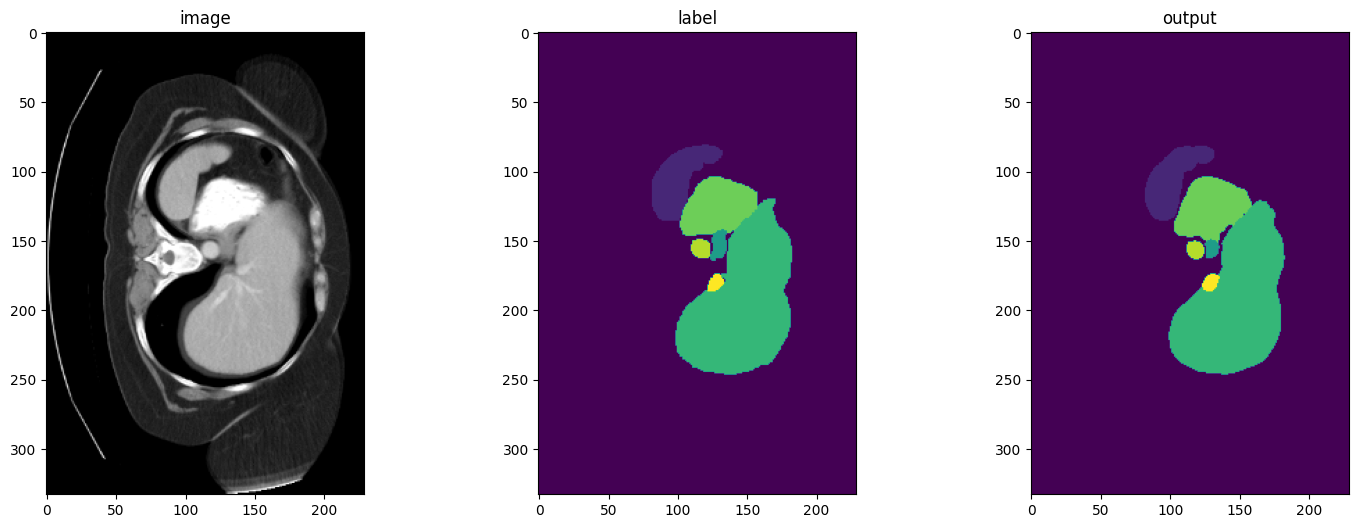

In [38]:
case_num = 4

with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [19]:
%run test.py --json_list='dataset_0.json' --data_dir='data/' --feature_size=48 --infer_overlap=0.5 --pretrained_model_name='test/model_final.pt' --pretrained_dir='runs/'

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:04,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:04,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-09 19:05:04,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-09 19:05:04,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-09 19:05:04,842 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:04,840 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:05,384 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:05,405 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:05,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2023-04-09 19:05:05,442 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:06,253 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-09 19:05:06,335 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Inference on case img0035.nii.gz
Mean Organ Dice: 0.7772576581352666
Inference on case img0036.nii.gz
Mean Organ Dice: 0.8418204855348491
Inference on case img0037.nii.gz
Mean Organ Dice: 0.8039230151449583
Inference on case img0038.nii.gz
Mean Organ Dice: 0.7768187323001317
Inference on case img0039.nii.gz
Mean Organ Dice: 0.843812745950703
Inference on case img0040.nii.gz
Mean Organ Dice: 0.8375876173609408
Overall Mean Dice: 0.8135367090711417
